In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [16]:
rcParams.update({'legend.fontsize': 'x-large',
                 'axes.labelsize': 'x-large',
                 'axes.titlesize': 'x-large',
                 'xtick.labelsize': 'x-large',
                 'ytick.labelsize': 'x-large',
                 'lines.markersize': 10})

# P5 - Localization of a Cell Phone

This exercise aims at showing how the Least-Squares-method can be used to estimate the
location of a cell phone using real measurments of run-times and run-time differences of signales
emitted by surrounding base stations. Consider the following scenario: A cell phone receives signals
of $K+1$ ($K>3$) surrounding base stations. The positions $\mathbf{a}_k = \begin{bmatrix} a_{k,x} &a_{k,y} \end{bmatrix}^T$ of
all $K+1$ different base stations are known in beforehand, with the position of the $0^{th}$ base
station to be the origin of the chosen coordinate system, i.e. $\mathbf{a}_0=\mathbf{0}$. The
position $\mathbf{a}_T=\begin{bmatrix} a_{T,x} &a_{T,y} \end{bmatrix}^T=\begin{bmatrix} x &y \end{bmatrix}^T$ of the cell phone (T stands for mobile
terminal) shall now be estimated using measured run-times and run-time differences of
the base station signals.

In [17]:
MS = np.array([5, 5])  # true position of the cell phone in km
K = 3  # Number of equations in the final set of equation
N = K + 1  # Number of base stations available

# Base station positions in km
BS = np.array([[0, 0], [-5, 6], [7, 8], [0, 15]])

a) First, consider given run-times $\tau_k$ ($k=0,...,K$) a signal emitted by base station $k$ takes to
the cell phone (so-called ''Time-of-Arrival''-method, TOA). Calculate the Least-Squares-Solution for given $K+1$ run-times (i.e. $K+1$ base
stations).

In [18]:
c = 3 * 1e2  # Propagation speed in km/ms
d_true = np.sqrt(np.sum((BS - MS) ** 2, axis=1)) # True distance between mobile station and base stations in km
t_true = d_true / c # True TOA in ms

# Measured TOAs are true TOAs corrupted by additive noise.
# Choose either random noise or given ones:
# noise = np.sqrt(0.00001) * np.random.normal(size=t_true.shape)
# noise = np.sqrt(0.0001) * np.random.uniform(-0.5, 0.5, size=t_true.shape)
noise = np.array([0.0001, 0.003, 0.0014, -0.0004])

noise = noise[:N]
t_measured = t_true + noise
d_measured = t_measured * c

In [19]:
# Calculate the Least-Squares-Solution
A = BS[1:] - BS[0]
b = -1/2 * (c ** 2 * (t_measured[1:] ** 2 - t_measured[0] ** 2) - np.linalg.norm(A, axis=1) ** 2)
a_TOA = np.linalg.solve(np.conj(A).T @ A, np.conj(A).T @ b)

Display the estimated position together with the $K+1$ circles given by points of
equal run-time to base station $k$ ($k=0,...,K$).

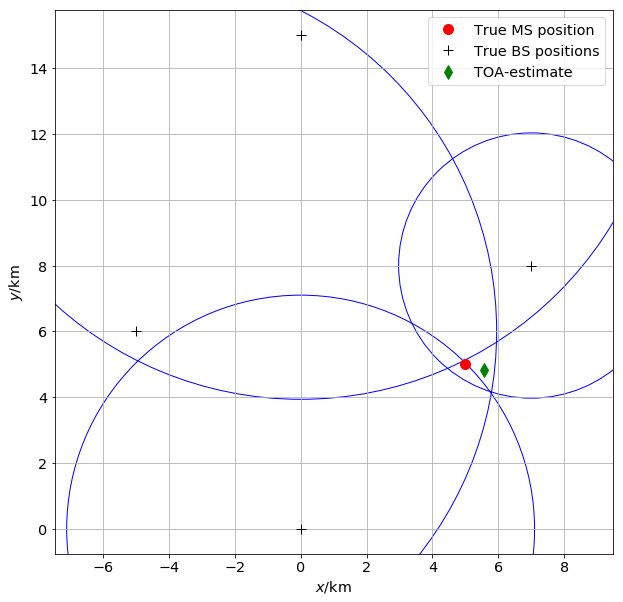

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

# Ground truth positions
ax.plot(MS[0], MS[1], 'ro', label='True MS position')
ax.plot(BS[:,0], BS[:,1], 'k+', label='True BS positions')

# Points of equal run-time
for bs, d_ in zip(BS, d_measured):
    ax.add_artist(plt.Circle(bs, d_, fill=False, color='b'))

# Results
ax.plot(a_TOA[0], a_TOA[1], 'gd', label='TOA-estimate')
ax.set_xlabel('$x$/km')
ax.set_ylabel('$y$/km')
plt.legend()
plt.axis('equal')
plt.grid()

In practice, the times the base stations emmit their signals are not known a priori. Thus,
estimation of the position of a cell phone cannot be based on run-times. But under the assumption
of all base stations emmitting their signals at the same time, run-time-differences
$\Delta\tau_{k,l}$ between the signals of the $k^{th}$ and the $l^{th}$ base station measured at the
cell phone can be used (so-called ''Time-Difference-of-Arrival''-method, TDOA). Assume given
run-time-differences (with respect to base station $0$) in the following.

b) The non-linear set of equations in $\mathbf{a}_{T}=\begin{bmatrix}x &y \end{bmatrix}^T$ can be interpreted as a linear set of equations in $\mathbf{w}=\begin{bmatrix}\|\mathbf{a}_T\| &x &y\end{bmatrix}^T$. Follow this approach and find the Least-Squares-solution for $\hat{\mathbf{w}}$.

In [21]:
# Calculate the run time differences with respect to BS 0
delta_tau_k_0 = t_measured[1:] - t_measured[0]

In [22]:
# Calculate the Least-Squares-Solution
B = np.concatenate([delta_tau_k_0[:, None] * c, A], axis=1)
d = 1/2 * (np.linalg.norm(A, axis=1) ** 2 - c ** 2 * delta_tau_k_0 ** 2)
w_TDOA = np.linalg.solve(B.T @ B, B.T @ d)
a_TDOA = np.array([[0, 1, 0], [0, 0, 1]]) @ w_TDOA

Display the estimated cell phone position together with the $K$ hyperbolas given by the points of equal run-time differences.

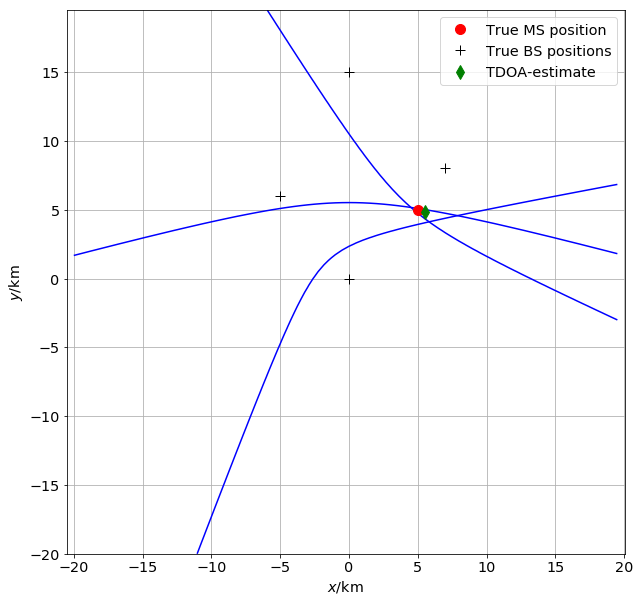

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

# Ground truth positions
ax.plot(MS[0], MS[1], 'ro', label='True MS position')
ax.plot(BS[:,0], BS[:,1], 'k+', label='True BS positions')

# Points of equal run-time differences
Dt_measured_0 = t_measured - t_measured[0]
# Calculate display size 
delta = 5;
xmax = np.maximum(np.max(BS[:,0]), a_TDOA[0]) + delta;
xmin = np.minimum(np.min(BS[:,0]), a_TDOA[0]) - delta;
ymax = np.maximum(np.max(BS[:,1]), a_TDOA[1]) + delta;
ymin = np.minimum(np.min(BS[:,1]), a_TDOA[1]) - delta;
x_lim = np.maximum(np.abs(xmax),np.abs(xmin));
y_lim = np.maximum(np.abs(ymax),np.abs(ymin));
lim = np.maximum(y_lim,x_lim);
#Display hyperbolas
delta = .5
for k in range(1, BS.shape[0]):
    x = np.arange(-lim, lim, delta)
    y = np.arange(-lim, lim, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.empty_like(X)
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            Z [ix, iy] = (np.sqrt( (BS[k, 0]-X[ix, iy])**2 + ( BS[k,1] - Y[ix, iy] ) ** 2) - np.sqrt((BS[0,0] - X[ix, iy]) ** 2 + (BS[0,1] - Y[ix, iy]) ** 2)) / c - Dt_measured_0[k]
    plt.contour(X,Y,Z, np.arange(5), colors='b')

# Results
ax.plot(a_TOA[0], a_TOA[1], 'gd', label='TDOA-estimate')
ax.set_xlabel('$x$/km')
ax.set_ylabel('$y$/km')
plt.legend()
plt.axis('equal')
plt.grid()

The previous approach does not account for the inherent dependencies in the vector $\mathbf{w}$:

In [24]:
print(f'w_TDOA[0] = ||a_T|| = {w_TDOA[0]} km')
print(f'||x^2 + y^2|| = {np.linalg.norm(w_TDOA[1:])} km')

w_TDOA[0] = ||a_T|| = 15.044357025992797 km
||x^2 + y^2|| = 10.988964773645478 km


Stating a constraint optimization problem which accounts for these dependencies leads to an equation
for the Lagrange-operator that cannot be solved in closed-form. Thus, the
alternative way of solving the optimization problem which was proposed in the corresponding theoretical part of this exercise shall now be examined. The alternative approach
rewrites the Least-Squares cost function
\begin{eqnarray*}
J(\mathbf{w}) &=& \|\mathbf{d}-\mathbf{B} \mathbf{w}\|^2 \\
&=& \left( \mathbf{d}-\mathbf{B} \mathbf{w} \right)^T \left( \mathbf{d}-\mathbf{B} \mathbf{w}
\right)
\end{eqnarray*}
to
\begin{eqnarray*}
J^\prime(\mathbf{w}) &=& \left( \mathbf{w}- \tilde{\mathbf{w}} \right)^T \mathbf{B}^T \mathbf{B}
\left( \mathbf{w}-\tilde{\mathbf{w}} \right).
\end{eqnarray*}
With $\tilde{\mathbf{w}}=\left(\mathbf{B}^T \mathbf{B}\right)^{-1} \mathbf{B}^T \mathbf{d}$ this new
cost function and the Least-Squares cost function are identical (to within a constant).
Linearizing the term $\mathbf{w}- \tilde{\mathbf{w}}=\mathbf{w}(\mathbf{a}_T) - \tilde{\mathbf{w}}$
for $\mathbf{a}_T$ in the vicinity of $\tilde{\mathbf{a}}_T$ by means of a Taylor series expansion
(i.e. $\mathbf{w}(\mathbf{a}_T) - \tilde{\mathbf{w}}$ is developed in a Taylor series at
$\tilde{\mathbf{a}}_T$ and all non-linear terms are discarded) transforms the nonlinear
costfunction $J(\mathbf{a}_T)$ into a linear cost function $J^\prime(\mathbf{a}_T)$.

c) Determine the Least-Squares-solution to the minimization problem of the alternative
cost function. Use the previous solution of the ''unconstraint'' TDOA-method as the point of
linearization.

In [25]:
# Calculate the Least-Squares-solution to the minimization problem of the alternative cost function J'(w)
a_TDOA_tilde = a_TDOA
w_tilde = w_TDOA
C = np.concatenate([[a_TDOA_tilde.T / np.sqrt(a_TDOA_tilde.T @ a_TDOA_tilde)], np.eye(2, 2)], axis=0)
delta = np.concatenate([[np.sqrt(a_TDOA_tilde.T @ a_TDOA_tilde)],  a_TDOA_tilde], axis=0) - w_tilde
a_TDOA_tilde = a_TDOA_tilde - np.linalg.solve(C.T @ B.T @ B @ C,  C.T @ B.T @ B @ delta)

Display the found position of the cell phone together with the estimated position given by the
''unconstraint'' TDOA-method and the $K$ hyperbolas specified by points of equal
run-time-differnces.

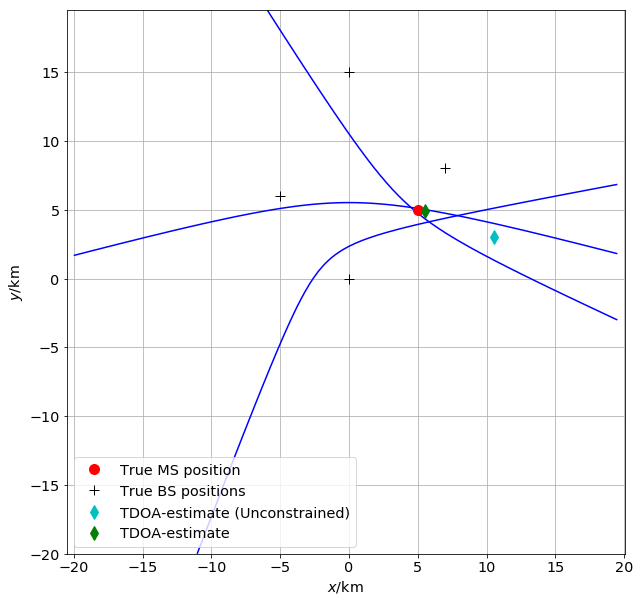

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

# Ground truth positions
ax.plot(MS[0], MS[1], 'ro', label='True MS position')
ax.plot(BS[:,0], BS[:,1], 'k+', label='True BS positions')

# Points of equal run-time differences
Dt_measured_0 = t_measured - t_measured[0]
# Calculate display size 
delta = 5;
xmax = np.maximum(np.max(BS[:,0]), a_TDOA[0]) + delta;
xmin = np.minimum(np.min(BS[:,0]), a_TDOA[0]) - delta;
ymax = np.maximum(np.max(BS[:,1]), a_TDOA[1]) + delta;
ymin = np.minimum(np.min(BS[:,1]), a_TDOA[1]) - delta;
x_lim = np.maximum(np.abs(xmax),np.abs(xmin));
y_lim = np.maximum(np.abs(ymax),np.abs(ymin));
lim = np.maximum(y_lim,x_lim);
#Display hyperbolas
delta = .5
for k in range(1, BS.shape[0]):
    x = np.arange(-lim, lim, delta)
    y = np.arange(-lim, lim, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.empty_like(X)
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            Z [ix, iy] = (np.sqrt( (BS[k, 0]-X[ix, iy])**2 + ( BS[k,1] - Y[ix, iy] ) ** 2) - np.sqrt((BS[0,0] - X[ix, iy]) ** 2 + (BS[0,1] - Y[ix, iy]) ** 2)) / c - Dt_measured_0[k]
    plt.contour(X,Y,Z, np.arange(5), colors='b')

# Results
ax.plot(a_TDOA[0], a_TDOA[1], 'cd', label='TDOA-estimate (Unconstrained)')
ax.plot(a_TDOA_tilde[0], a_TDOA_tilde[1], 'gd', label='TDOA-estimate')
ax.set_xlabel('$x$/km')
ax.set_ylabel('$y$/km')
plt.legend()
plt.axis('equal')
plt.grid()

d) As shown in the last problem of the corresponding theoretical exercise, the alternative solution is
equivalent to an iteration of a Newton-algorithm applied to the alternative cost function and
initialized at $\tilde{\mathbf{a}}_T$. Continue by iteratively putting the found solution into the
given equation, i.e. use the solution of the previous iteration as the new point of linearization.

In [27]:
a_TDOA_newton = a_TDOA
w_newton = w_TDOA
num_it = 1000  # Iterations for the Newton algorithm
for i in range(num_it):
    C = np.concatenate([[a_TDOA_newton.T / np.sqrt(a_TDOA_newton.T @ a_TDOA_newton)], np.eye(2, 2)], axis=0)
    delta = np.concatenate([[np.sqrt(a_TDOA_newton.T @ a_TDOA_newton)],  a_TDOA_newton], axis=0) - w_newton
    a_TDOA_newton = a_TDOA_newton - np.linalg.solve(C.T @ B.T @ B @ C,  C.T @ B.T @ B @ delta)
    w_newton = np.concatenate([[np.linalg.norm(a_TDOA_newton)], a_TDOA_newton], axis=0)

## Error of the approaches

In [28]:
e_TOA = np.sqrt((a_TOA - MS) @ (a_TOA - MS))
e_TDOA = np.sqrt((a_TDOA - MS) @ (a_TDOA - MS))
e_TDOA_tilde = np.sqrt((a_TDOA_tilde - MS) @ (a_TDOA_tilde - MS))
e_TDOA_newton = np.sqrt((a_TDOA_newton - MS) @ (a_TDOA_newton - MS))

print(f'TOA: {e_TOA} km')
print(f'TDOA (unconstrained): {e_TDOA} km')
print(f'TDOA: {e_TDOA_tilde} km')
print(f'TDOA (Newton-method): {e_TDOA_newton} km')

TOA: 0.582881826996427 km
TDOA (unconstrained): 5.915701492494486 km
TDOA: 0.5021976548978512 km
TDOA (Newton-method): 0.5021976548978512 km
